<a href="https://colab.research.google.com/github/porori1224/2024_Chosun_osp_Deepfake-detection-Challenge/blob/porori1224/KMS_Try_Code/Noise_Addition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [225]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [226]:
import os
# check the current path
print(os.getcwd()) # /content

# You should copy the path : 왼쪽 폴더에서 오른쪽 버튼 후 경로복사
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW')

print(os.getcwd()) # path has been changed

/content/gdrive/My Drive/Colab Notebooks/KMS_OSP_SW
/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW


In [3]:
!pip install retina-face

In [4]:
!pip install torch torchvision torchaudio

In [5]:
# 필요시 설치
!pip install scikit-learn matplotlib

In [6]:
!pip install timm

In [222]:
import pandas as pd
import json

# 경로 설정
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01"
folders = ["dfdc_train_part_0", "dfdc_train_part_1"]
output_dir = os.path.join(base_dir, "processed_videos")
os.makedirs(output_dir, exist_ok=True)

# 데이터프레임 초기화
combined_df = pd.DataFrame()

# 각 폴더에서 데이터를 읽고 합치기
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    json_file = os.path.join(folder_path, "metadata.json")

    # JSON 파일 로드
    with open(json_file, "r") as f:
        metadata = json.load(f)

    # JSON 데이터를 DataFrame으로 변환
    df = pd.DataFrame.from_dict(metadata, orient="index").reset_index()
    df.columns = ["filename", "label", "split", "original"]
    df["label"] = df["label"].map({"FAKE": 0, "REAL": 1})

    # 파일 경로 추가
    df["filepath"] = df["filename"].apply(lambda x: os.path.join(folder_path, x))

    # 데이터프레임 병합
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# 병합 결과 확인
print(f"Total videos in combined dataset: {len(combined_df)}")
print(combined_df["label"].value_counts())

# 데이터 저장 (원한다면 Pickle로 저장)
combined_pickle_path = os.path.join(base_dir, "combined_metadata.pkl")
combined_df.to_pickle(combined_pickle_path)
print(f"Combined metadata saved to: {combined_pickle_path}")

Total videos in combined dataset: 3033
label
0    2839
1     194
Name: count, dtype: int64
Combined metadata saved to: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01/combined_metadata.pkl


In [227]:
# JSON 데이터를 데이터프레임으로 변환
df = pd.DataFrame.from_dict(metadata, orient="index").reset_index()
df.columns = ["filename", "label", "split", "original"]

# 라벨링을 0과 1로 매핑
label_mapping = {"FAKE": 0, "REAL": 1}
df["label"] = df["label"].map(label_mapping)

# 매핑되지 않은 라벨 확인 및 처리
if df["label"].isnull().any():
    print("Warning: Some labels were not mapped correctly.")
    unmapped_labels = df[df["label"].isnull()]
    print(f"Unmapped labels:\n{unmapped_labels}")
    # unmapped_labels를 기록하거나, 원하는 디폴트 값으로 설정 가능
    df["label"] = df["label"].fillna(-1)  # 예: -1로 설정

In [228]:
# 데이터프레임에서 필요한 컬럼만 출력하도록 정리
print(f"Total data size: {len(df)}")
print(df[["filename", "label", "split", "original"]].head(10))

# 경로 설정
base_dir_0 = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01/dfdc_train_part_0"
base_dir_1 = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01/dfdc_train_part_1"

# 경로 설정 함수 생성 (폴더 선택 로직)
def determine_base_dir(filename):
    if filename in os.listdir(base_dir_0):
        return os.path.join(base_dir_0, filename)
    elif filename in os.listdir(base_dir_1):
        return os.path.join(base_dir_1, filename)
    else:
        return None  # 파일이 존재하지 않을 경우

# 비디오 파일 경로 생성
df["filepath"] = df["filename"].apply(determine_base_dir)

# 경로가 존재하지 않는 파일 확인 및 출력
missing_files = df[df["filepath"].isnull()]
if not missing_files.empty:
    print(f"Warning: {len(missing_files)} files are missing:")
    print(missing_files[["filename"]])

Total data size: 1699
         filename  label  split        original
0  zumqqvixhu.mp4      0  train  hntguogkqd.mp4
1  utdlsqfykm.mp4      0  train  nswtvttxre.mp4
2  mdfndlljvt.mp4      0  train  ptkcmwnfjv.mp4
3  maktypgsfl.mp4      0  train  objgwnmscm.mp4
4  pleqihjpif.mp4      0  train  xrhqtmxlvx.mp4
5  yejvlyggtw.mp4      0  train  mwwploizlj.mp4
6  yotsfuryir.mp4      0  train  dvwpvqdflx.mp4
7  tguqyatciq.mp4      0  train  lujvyveojc.mp4
8  fjzrvkleur.mp4      0  train  gylcfcozce.mp4
9  kylqyoxeqm.mp4      0  train  zwswwwrefl.mp4


KeyboardInterrupt: 

In [229]:
import os
import pandas as pd
import json
import cv2
from retinaface import RetinaFace
from multiprocessing import Pool
from torchvision import transforms
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pickle


# 경로 설정
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW"
input_dirs = [
    os.path.join(base_dir, "00~01/dfdc_train_part_0"),
    os.path.join(base_dir, "00~01/dfdc_train_part_1")
]
output_dir = os.path.join(base_dir, "processed_videos")
os.makedirs(output_dir, exist_ok=True)

# 비디오 처리 함수
skipped_videos = set()  # 중복 방지
data_augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

def process_video(video_info):
    video_path, output_path = video_info
    try:
        # 비디오 열기
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Skipping invalid video: {video_path}")
            skipped_videos.add(video_path)
            return None

        # 프레임 읽기
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        mid_frame_idx = frame_count // 2
        random_frame_idx = random.randint(0, frame_count - 1)
        selected_frames = [mid_frame_idx, random_frame_idx]

        frames = []
        for idx in range(frame_count):
            ret, frame = cap.read()
            if not ret:
                break
            if idx in selected_frames:
                frames.append(frame)
        cap.release()

        if not frames:
            print(f"No frames selected: {video_path}")
            skipped_videos.add(video_path)
            return None

        # 얼굴 감지 및 데이터 증강
        for frame in frames:
            resized_frame = cv2.resize(frame, (160, 90))  # 해상도 축소
            faces = RetinaFace.detect_faces(resized_frame)
            if isinstance(faces, dict) and faces:
                bbox = list(faces.values())[0]["facial_area"]
                cropped_face = resized_frame[bbox[1]:bbox[3], bbox[0]:bbox[2]]

                # 데이터 증강
                augmented_face = data_augment(cropped_face)

                # 이미지 저장
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                augmented_image = transforms.ToPILImage()(augmented_face)
                augmented_image.save(output_path)
                print(f"Processed and saved: {output_path}")
                return output_path

        print(f"Skipping video without detectable faces: {video_path}")
        skipped_videos.add(video_path)
        return None

    except Exception as e:
        print(f"Error processing {video_path}: {e}")
        skipped_videos.add(video_path)
        return None


In [18]:
# 비디오 정보 리스트 생성
video_info_list = []
for input_dir in input_dirs:
    video_info_list.extend([
        (os.path.join(input_dir, filename), os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_processed.jpg"))
        for filename in os.listdir(input_dir) if filename.endswith(".mp4")
    ])

# 병렬 처리 함수
def process_videos_in_parallel(video_info_list, num_processes=os.cpu_count()):
    with Pool(processes=num_processes) as pool:
        results = pool.map(process_video, video_info_list)
    return results

In [19]:
# 실행
if __name__ == "__main__":
    print("Starting optimized video processing...")
    processed_files = process_videos_in_parallel(video_info_list, num_processes=4)
    print("Processing complete.")

    # 스킵된 비디오 저장
    skipped_videos_path = os.path.join(base_dir, "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/skipped_videos.txt")
    with open(skipped_videos_path, "w") as f:
        for video in skipped_videos:
            f.write(f"{video}\n")
    print(f"Skipped videos saved to: {skipped_videos_path}")

Starting optimized video processing...
Skipping video without detectable faces: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01/dfdc_train_part_0/wbdpryfqgy.mp4
Skipping video without detectable faces: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01/dfdc_train_part_0/wdcrhqtjhf.mp4
Processed and saved: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/processed_videos/kstmekinaw_processed.jpgProcessed and saved: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/processed_videos/yajhwipypq_processed.jpg

Skipping video without detectable faces: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01/dfdc_train_part_0/fzkzqwoghs.mp4
Skipping video without detectable faces: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01/dfdc_train_part_0/culaevxduf.mp4
Skipping video without detectable faces: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/00~01/dfdc_train_part_0/ygngdbjmox.mp4
Skipping video without detectable faces: /content/gdrive/MyDrive/Colab Noteboo

In [275]:
import os
import pandas as pd

# 경로 설정
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW"
processed_dir = os.path.join(base_dir, "processed_videos")
skipped_videos_path = os.path.join(base_dir, "skipped_videos.txt")

# 처리된 파일 로드
processed_files = os.listdir(processed_dir)
print(f"Total processed files: {len(processed_files)}")
print(f"Sample processed files: {processed_files[:5]}")

# 스킵된 비디오 로드
with open(skipped_videos_path, "r") as f:
    skipped_videos = f.readlines()
skipped_videos = [x.strip() for x in skipped_videos]
print(f"Total skipped videos: {len(skipped_videos)}")
print(f"Sample skipped videos: {skipped_videos[:5]}")

Total processed files: 2920
Sample processed files: ['lslmnvlhhe_processed.jpg', 'tdspbqidzz_processed.jpg', 'rnfvcslcmf_processed.jpg', 'phjlaexgcl_processed.jpg', 'xtegzrbvaz_processed.jpg']
Total skipped videos: 0
Sample skipped videos: []


In [276]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Real 데이터 증강 함수 (잡음 추가 및 복사)
def augment_real_data(real_df, factor=2):
    augmented_data = []
    for i in range(factor):  # 증강 배율 만큼 반복
        copy_df = real_df.copy()
        copy_df["filename"] = copy_df["filename"].apply(lambda x: f"aug_{i}_{x}")  # 파일명 변경
        augmented_data.append(copy_df)
    return pd.concat(augmented_data, ignore_index=True)


In [277]:
# 데이터 균형 조정 및 분리
def balance_and_split_data(df, test_size=0.2, val_size=0.2, augment_factor=2):
    fake_df = df[df["label"] == 0]
    real_df = df[df["label"] == 1]

    # Real 데이터 증강
    augmented_real_df = augment_real_data(real_df, factor=augment_factor)

    # Fake 데이터와 증강된 Real 데이터 병합
    balanced_df = pd.concat([augmented_real_df, fake_df]).sample(frac=1, random_state=42).reset_index(drop=True)

    # 데이터 분리 (80% Train + Validation, 20% Test)
    train_val_df, test_df = train_test_split(
        balanced_df,
        test_size=test_size,
        random_state=42,
        stratify=balanced_df["label"]
    )

    # Train과 Validation 데이터 분리 (Train: 80%, Validation: 20%)
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_size,
        random_state=42,
        stratify=train_val_df["label"]
    )

    return train_df, val_df, test_df

In [278]:
# 라벨 매핑 함수 수정
def create_labels(df, processed_files):
    labels = {}
    unmatched_files = []
    for filename, label in zip(df["filename"], df["label"]):
        base_filename = os.path.splitext(filename)[0]  # 확장자 제거
        processed_filename = f"{base_filename}_processed.jpg"
        if processed_filename in processed_files:
            labels[processed_filename] = label
        else:
            unmatched_files.append(processed_filename)  # 매칭되지 않은 파일

    # 매칭되지 않은 파일 출력
    print(f"Unmatched files: {len(unmatched_files)}")
    print(f"Sample unmatched files: {unmatched_files[:5]}")
    print(f"Matched files: {len(labels)}")
    return labels

# 라벨 매핑 생성
train_labels = create_labels(train_df, processed_files)
val_labels = create_labels(val_df, processed_files)
test_labels = create_labels(test_df, processed_files)

# Split 열 업데이트 (중복 방지)
for df, split in zip([train_df, val_df, test_df], ["train", "validation", "test"]):
    df["split"] = split

Unmatched files: 322
Sample unmatched files: ['aug_0_hjhdhumvod_processed.jpg', 'aug_1_iyrafvzjnf_processed.jpg', 'aug_0_frqfsucgao_processed.jpg', 'aug_0_xmkwsnuzyq_processed.jpg', 'aug_1_cosghhimnd_processed.jpg']
Matched files: 1742
Unmatched files: 82
Sample unmatched files: ['bbxqtnztyy_processed.jpg', 'aug_0_gylcfcozce_processed.jpg', 'ngnoguzzkd_processed.jpg', 'aug_1_opsgvfjlgh_processed.jpg', 'aug_0_prmwoaeeng_processed.jpg']
Matched files: 435
Unmatched files: 92
Sample unmatched files: ['aug_1_frqfsucgao_processed.jpg', 'fuiglusbnl_processed.jpg', 'aug_1_jzupayeuln_processed.jpg', 'ueobjeflda_processed.jpg', 'aug_0_ocnqcaojtf_processed.jpg']
Matched files: 554


In [280]:
# 경로 설정
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW"
processed_dir = os.path.join(base_dir, "processed_videos")
processed_files = set(os.listdir(processed_dir))  # 처리된 파일 목록 가져오기

In [281]:
# JSON 파일 로드 및 데이터프레임 생성
input_dirs = [
    os.path.join(base_dir, "00~01/dfdc_train_part_0"),
    os.path.join(base_dir, "00~01/dfdc_train_part_1")
]
dataframes = []
for input_dir in input_dirs:
    json_path = os.path.join(input_dir, "metadata.json")
    with open(json_path, "r") as f:
        metadata = pd.DataFrame.from_dict(json.load(f), orient="index").reset_index()
    metadata.columns = ["filename", "label", "split", "original"]
    metadata["label"] = metadata["label"].map({"FAKE": 0, "REAL": 1})
    dataframes.append(metadata)

df = pd.concat(dataframes, ignore_index=True)


In [282]:
# 데이터 균형 조정 및 분리 호출
train_df, val_df, test_df = balance_and_split_data(df, augment_factor=2)

# 처리된 파일 목록 가져오기
processed_dir = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/processed_videos"
processed_files = set(os.listdir(processed_dir))

# 라벨 매핑 생성
train_labels = create_labels(train_df, processed_files)
val_labels = create_labels(val_df, processed_files)
test_labels = create_labels(test_df, processed_files)

# Split 열 업데이트 (중복 방지)
for df, split in zip([train_df, val_df, test_df], ["train", "validation", "test"]):
    df["split"] = split

Unmatched files: 322
Sample unmatched files: ['aug_0_hjhdhumvod_processed.jpg', 'aug_1_iyrafvzjnf_processed.jpg', 'aug_0_frqfsucgao_processed.jpg', 'aug_0_xmkwsnuzyq_processed.jpg', 'aug_1_cosghhimnd_processed.jpg']
Matched files: 1742
Unmatched files: 82
Sample unmatched files: ['bbxqtnztyy_processed.jpg', 'aug_0_gylcfcozce_processed.jpg', 'ngnoguzzkd_processed.jpg', 'aug_1_opsgvfjlgh_processed.jpg', 'aug_0_prmwoaeeng_processed.jpg']
Matched files: 435
Unmatched files: 92
Sample unmatched files: ['aug_1_frqfsucgao_processed.jpg', 'fuiglusbnl_processed.jpg', 'aug_1_jzupayeuln_processed.jpg', 'ueobjeflda_processed.jpg', 'aug_0_ocnqcaojtf_processed.jpg']
Matched files: 554


In [283]:
# 데이터 크기 확인
print("\nBalanced Data Distribution:")
print(f"Train size: {len(train_df)} (Classes: {train_df['label'].value_counts().to_dict()})")
print(f"Validation size: {len(val_df)} (Classes: {val_df['label'].value_counts().to_dict()})")
print(f"Test size: {len(test_df)} (Classes: {test_df['label'].value_counts().to_dict()})")

print("\nExample Labels (Train):", list(train_labels.items())[:5])
print("\nExample Labels (Validation):", list(val_labels.items())[:5])
print("\nExample Labels (Test):", list(test_labels.items())[:5])


Balanced Data Distribution:
Train size: 2064 (Classes: {0: 1816, 1: 248})
Validation size: 517 (Classes: {0: 455, 1: 62})
Test size: 646 (Classes: {0: 568, 1: 78})

Example Labels (Train): [('rcecrgeotc_processed.jpg', 0), ('spkkvmcbmy_processed.jpg', 0), ('zvkxhhtvlx_processed.jpg', 0), ('sdorhlibip_processed.jpg', 0), ('rtuthjqxrg_processed.jpg', 0)]

Example Labels (Validation): [('ykiiuksurb_processed.jpg', 0), ('snqpxfecxh_processed.jpg', 0), ('awigxxbbpb_processed.jpg', 0), ('dcwnkxrsgg_processed.jpg', 0), ('hthuorhwdn_processed.jpg', 0)]

Example Labels (Test): [('ootmykhdga_processed.jpg', 0), ('kumfnjadhi_processed.jpg', 0), ('cglveitybx_processed.jpg', 0), ('phunswkrpy_processed.jpg', 0), ('zqodmfrtbs_processed.jpg', 0)]


In [267]:
# processed_files 목록 출력
print("Processed files (sample):", list(processed_files)[:10])

# 데이터프레임의 파일명 예제 출력
print("DataFrame filenames (sample):", train_df["filename"].head(10).tolist())

Processed files (sample): ['ezbyfrzjqx_processed.jpg', 'apzckowxpy_processed.jpg', 'hasjjkoygr_processed.jpg', 'gunamloolc_processed.jpg', 'xvzjzkrmlm_processed.jpg', 'xwqucxeryw_processed.jpg', 'zmndlwmybr_processed.jpg', 'dtjcyzgdts_processed.jpg', 'gkqitjodaa_processed.jpg', 'wcssbghcpc_processed.jpg']
DataFrame filenames (sample): ['rcecrgeotc.mp4', 'spkkvmcbmy.mp4', 'zvkxhhtvlx.mp4', 'sdorhlibip.mp4', 'aug_0_hjhdhumvod.mp4', 'rtuthjqxrg.mp4', 'cpxzktdxsi.mp4', 'aug_1_iyrafvzjnf.mp4', 'cmwqaulwau.mp4', 'imndwwlfui.mp4']


In [238]:
# 데이터 저장 전에 확인
print("Verifying dataset sizes before saving...")
print(f"Train data size: {len(train_df)}, Validation data size: {len(val_df)}, Test data size: {len(test_df)}")

# Pickle 저장 경로
train_pickle_path = os.path.join(base_dir, "train_split.pkl")
val_pickle_path = os.path.join(base_dir, "val_split.pkl")
test_pickle_path = os.path.join(base_dir, "test_split.pkl")

# Pickle 저장
pickle_paths = {"Train": train_pickle_path, "Validation": val_pickle_path, "Test": test_pickle_path}
datasets = {"Train": train_df, "Validation": val_df, "Test": test_df}

for split, path in pickle_paths.items():
    with open(path, "wb") as f:
        pickle.dump(datasets[split], f)
    print(f"{split} data saved to: {path}")

Verifying dataset sizes before saving...
Train data size: 2064, Validation data size: 517, Test data size: 646
Train data saved to: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/train_split.pkl
Validation data saved to: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/val_split.pkl
Test data saved to: /content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/test_split.pkl
Testing saved Pickle files...
Loaded Train data size: 2064
Loaded Validation data size: 517
Loaded Test data size: 646


In [284]:
print(f"Number of test labels: {len(test_labels)}")
print(f"Sample test labels: {list(test_labels.items())[:5]}")

Number of test labels: 554
Sample test labels: [('ootmykhdga_processed.jpg', 0), ('kumfnjadhi_processed.jpg', 0), ('cglveitybx_processed.jpg', 0), ('phunswkrpy_processed.jpg', 0), ('zqodmfrtbs_processed.jpg', 0)]


Training Ensemble Model...


Epoch 1/10: 100%|██████████| 109/109 [00:47<00:00,  2.31it/s]


Epoch 1, Loss: 0.0010


Epoch 2/10: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]


Epoch 2, Loss: 0.0000


Epoch 3/10: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]


Epoch 3, Loss: 0.0000


Epoch 4/10: 100%|██████████| 109/109 [00:16<00:00,  6.43it/s]


Epoch 4, Loss: 0.0000


Epoch 5/10: 100%|██████████| 109/109 [00:16<00:00,  6.49it/s]


Epoch 5, Loss: 0.0000


Epoch 6/10: 100%|██████████| 109/109 [00:16<00:00,  6.51it/s]


Epoch 6, Loss: 0.0000


Epoch 7/10: 100%|██████████| 109/109 [00:16<00:00,  6.49it/s]


Epoch 7, Loss: 0.0000


Epoch 8/10: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]


Epoch 8, Loss: 0.0000


Epoch 9/10: 100%|██████████| 109/109 [00:16<00:00,  6.49it/s]


Epoch 9, Loss: 0.0000


Epoch 10/10: 100%|██████████| 109/109 [00:16<00:00,  6.47it/s]


Epoch 10, Loss: 0.0000


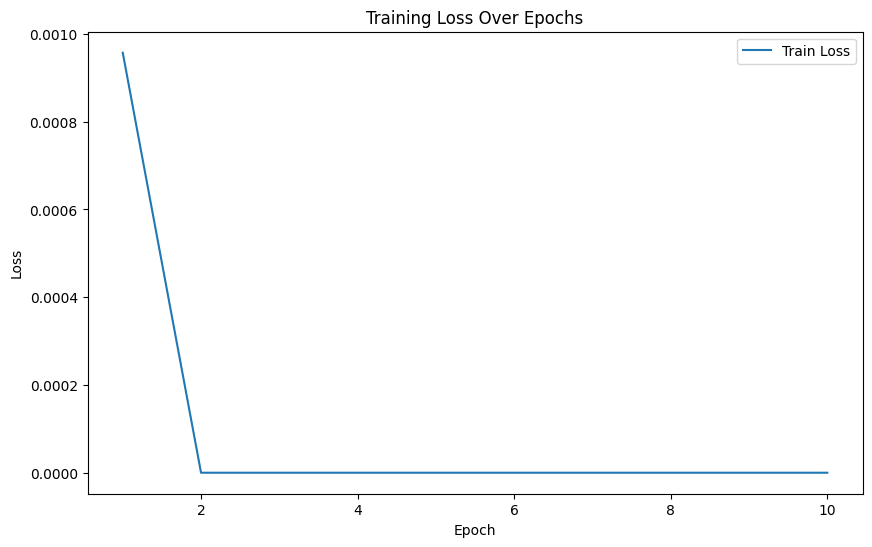

Evaluating on Validation Set...

Validation Dataset Evaluation Metrics:
Accuracy: 100.00%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%


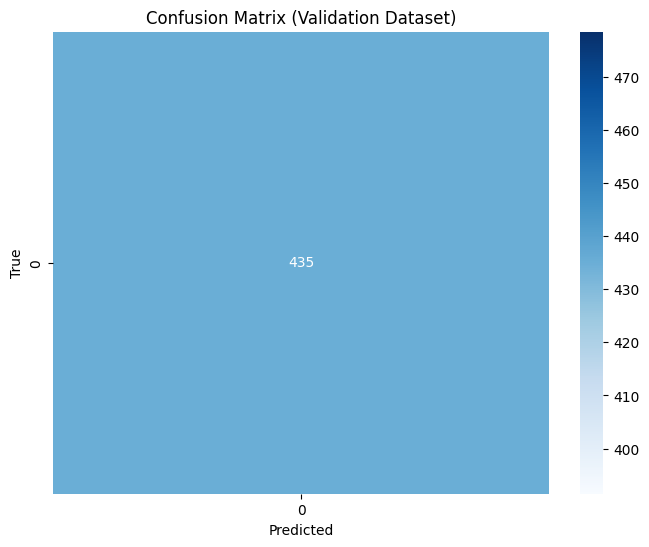

Evaluating on Test Set...

Test Dataset Evaluation Metrics:
Accuracy: 100.00%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%


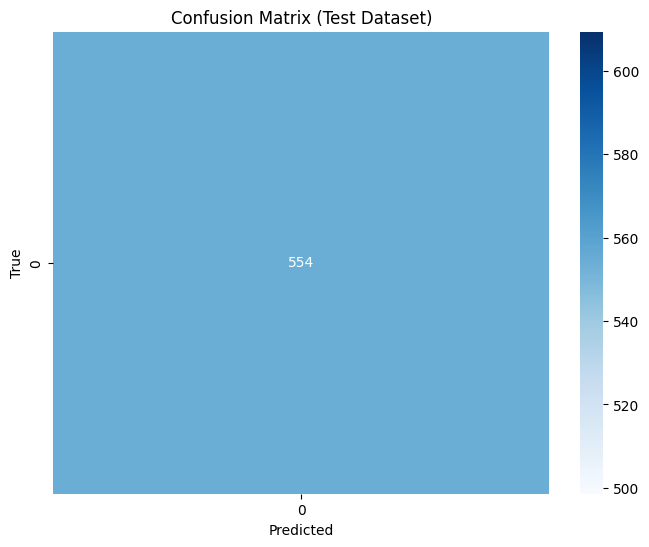

In [285]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from timm import create_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# 처리된 파일 목록 가져오기
processed_dir = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/processed_videos"
processed_files = set(os.listdir(processed_dir))

# 데이터프레임 로드
train_pickle_path = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/train_split.pkl"
val_pickle_path = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/val_split.pkl"
test_pickle_path = "/content/gdrive/MyDrive/Colab Notebooks/KMS_OSP_SW/test_split.pkl"

# Pickle 파일에서 데이터프레임 로드
import pickle
with open(train_pickle_path, "rb") as f:
    train_df = pickle.load(f)
with open(val_pickle_path, "rb") as f:
    val_df = pickle.load(f)
with open(test_pickle_path, "rb") as f:
    test_df = pickle.load(f)

# -------------------------------
# 데이터셋 클래스 정의
# -------------------------------
class ImageDataset(Dataset):
    def __init__(self, image_dir, label_dict, transform=None):
        self.image_dir = image_dir
        self.label_dict = label_dict
        self.image_files = list(label_dict.keys())
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        label = self.label_dict[image_file]
        image_path = os.path.join(self.image_dir, image_file)

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None, None

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# -------------------------------
# 데이터 처리
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 및 DataLoader
train_dataset = ImageDataset(processed_dir, train_labels, transform=transform)
val_dataset = ImageDataset(processed_dir, val_labels, transform=transform)
test_dataset = ImageDataset(processed_dir, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# EfficientNet-B0 모델 정의
class EfficientNetB0(nn.Module):
    def __init__(self, pretrained=True):
        super(EfficientNetB0, self).__init__()
        self.model = create_model("efficientnet_b0", pretrained=pretrained)
        self.model.reset_classifier(0)

    def forward(self, x):
        return self.model.forward_features(x)

# ConvNext-Tiny 모델 정의
class ConvNextTiny(nn.Module):
    def __init__(self, pretrained=True):
        super(ConvNextTiny, self).__init__()
        self.model = create_model("convnext_tiny", pretrained=pretrained)
        self.model.reset_classifier(0)

    def forward(self, x):
        return self.model.forward_features(x)

# 앙상블 모델 정의
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2, num_classes=1):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.fc = nn.Linear(num_classes * 2, num_classes)

    def forward(self, x):
        output1 = self.model1(x)
        output2 = self.model2(x)
        combined = torch.cat((output1, output2), dim=1)
        return self.fc(combined)

# FocalLoss 정의
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        probs = torch.sigmoid(inputs)
        p_t = targets * probs + (1 - targets) * (1 - probs)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * bce_loss
        return focal_loss.mean()

# -------------------------------
# 모델 초기화
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_b0 = create_model("efficientnet_b0", pretrained=True)
efficientnet_b0.reset_classifier(1)
convnext_tiny = create_model("convnext_tiny", pretrained=True)
convnext_tiny.reset_classifier(1)

ensemble_model = EnsembleModel(efficientnet_b0, convnext_tiny).to(device)

# -------------------------------
# 학습 및 평가
# -------------------------------
def train_model(model, loader, optimizer, criterion, num_epochs=5):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        epoch_loss = running_loss / len(loader)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.show()

# 모델 평가 함수
def evaluate_model(model, data_loader, dataset_name="Dataset"):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.flatten())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n{dataset_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.show()

# -------------------------------
# 실행
# -------------------------------
criterion = FocalLoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=1e-4)

# 학습 실행
print("Training Ensemble Model...")
train_model(ensemble_model, train_loader, optimizer, criterion, num_epochs=10)

print("Evaluating on Validation Set...")
evaluate_model(ensemble_model, val_loader, dataset_name="Validation Dataset")

print("Evaluating on Test Set...")
evaluate_model(ensemble_model, test_loader, dataset_name="Test Dataset")

In [218]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 모델 평가 함수 (Train, Validation, Test 공통)
def evaluate_model(model, data_loader, dataset_name="Dataset"):
    model.eval()  # 평가 모드로 전환
    y_true = []
    y_pred = []

    # GPU/CPU 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for images, labels in data_loader:
            # 데이터를 GPU/CPU로 이동
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # 실제 라벨 저장
            y_true.extend(labels.cpu().numpy())  # CPU로 이동하여 numpy로 변환

            # 모델 예측
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()  # Sigmoid 활성화 함수
            y_pred.extend((preds > 0.5).astype(int).flatten())  # 0.5 이상이면 1로 변환

    # 성능 지표 계산
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # 결과 출력
    print(f"\n{dataset_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")

# Train 데이터 평가
print("Evaluating Train Data...")
evaluate_model(ensemble_model, train_loader, dataset_name="Train Dataset")

# Validation 데이터 평가
print("\nEvaluating Validation Data...")
evaluate_model(ensemble_model, val_loader, dataset_name="Validation Dataset")

# Test 데이터 평가
print("\nEvaluating Test Data...")
evaluate_model(ensemble_model, test_loader, dataset_name="Test Dataset")

Evaluating Train Data...

Train Dataset Evaluation Metrics:
Accuracy: 100.00%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%

Evaluating Validation Data...

Validation Dataset Evaluation Metrics:
Accuracy: 100.00%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%

Evaluating Test Data...

Test Dataset Evaluation Metrics:
Accuracy: 100.00%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%
